In [2]:
# Applied Machine Learning at Scale (First draft)

# Onintsoa ANJARA RAKOTONDRANISA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
ratings = "ratings25m.csv"

In [3]:
import csv

with open(ratings) as r:
    ratings_reader = csv.reader(r)
    next(ratings_reader)
    ratings_reader = list(ratings_reader)

In [4]:
len(ratings_reader)

25000095

In [5]:
# Create the data structure

map_user_to_index={}
map_index_to_user=[]

map_movie_to_index={}
map_index_to_movie=[]

data_by_user_index = []
data_by_movie_index = []


user_index = 0
movie_index = 0

for i in ratings_reader:
    us_index = int(i[0])
    mov_index = int(i[1])
    rat_index = float(i[2])

    if us_index not in map_user_to_index:
        map_user_to_index[us_index] = user_index
        map_index_to_user.append(us_index)
        data_by_user_index.append([])
        user_index += 1

    if mov_index not in map_movie_to_index:
        map_movie_to_index[mov_index] = movie_index
        map_index_to_movie.append(mov_index)
        data_by_movie_index.append([])
        movie_index += 1

    up_user_index = map_user_to_index[us_index]
    up_movie_index = map_movie_to_index[mov_index]

    data_by_user_index[up_user_index].append((up_movie_index, rat_index))
    data_by_movie_index[up_movie_index].append((up_user_index, rat_index))


# Degree distribution

In [7]:
degree_user = [len(i) for i in data_by_user_index]
degree_item = [len(j) for j in data_by_movie_index]

freq_user = [degree_user.count(k) for k in degree_user]
freq_item = [degree_item.count(l) for l in degree_item]

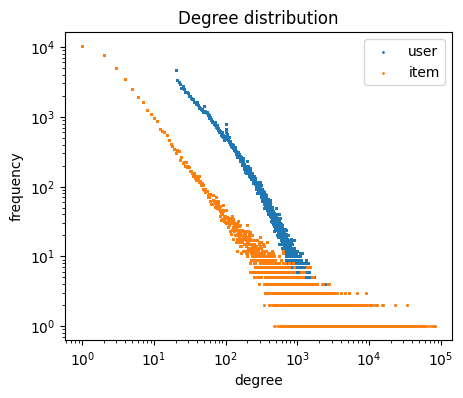

In [8]:
fig, ax = plt.subplots(figsize = (5, 4))

ax.scatter(np.array(degree_user), np.array(freq_user), s=1, label = 'user')
ax.scatter(np.array(degree_item), np.array(freq_item), s=1, label = 'item')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('degree')
ax.set_ylabel('frequency')
ax.set_title('Degree distribution')
ax.legend();

plt.savefig('power_law.pdf', format='pdf')

# Split the data into test and training set

In [12]:
def split_into_train_and_test(data, split_value=0.1):

  data_train = []
  data_test = []

  for i in range(len(data)):
    data_train.append([])
    data_test.append([])

    for j in data[i]:
      if np.random.rand() < split_value:
        data_test[i].append(j)
      else:
        data_train[i].append(j)

  return data_train, data_test

In [13]:
# Spit the data into training and test setplt
data_by_user_train, data_by_user_test = split_into_train_and_test(data_by_user_index)
data_by_item_train, data_by_item_test = split_into_train_and_test(data_by_movie_index)

print(len(data_by_user_index))
print(len(data_by_user_train))
print(len(data_by_user_test))

162541
162541
162541


In [14]:
print(len(data_by_movie_index))
print(len(data_by_item_train))
print(len(data_by_item_test))

59047
59047
59047


In [9]:
len(map_user_to_index) # number of users
print(len(map_movie_to_index)) # number of movies

59047


## Bias only

In [9]:
def compute_loss_and_rmse_bias_only(
  data_by_usr,
  data_by_itm,
  user_biases,
  item_biases,
  lambd = 0.01,
  gamma = 0.01,
  epoch = 50,
  ):

  all_loss = []
  all_rmse = []

  for i in range(epoch):
    # Update user biasesplt
    for m in range(len(data_by_usr)):
        bias = 0
        item_counter = 0
        for (n, r) in data_by_usr[m]:
            bias += lambd * (r - item_biases[n])
            item_counter += 1

        bias = bias / (lambd * item_counter + gamma)
        user_biases[m] = bias

    # Update item biases
    for n in range(len(data_by_itm)):
        bias = 0
        user_counter = 0
        for (m, r) in data_by_itm[n]:
            bias += lambd * (r - user_biases[m])
            user_counter += 1

        bias = bias / (lambd * user_counter + gamma)
        item_biases[n] = bias

    # Compute loss after updating biases
    loss_one = 0
    rmse_one = 0
    counter = 0
    for m in range(len(data_by_usr)):
        for (n, r) in data_by_usr[m]:
            error = r - user_biases[m] - item_biases[n]
            loss_one += ( lambd / 2) * (error ** 2) + (gamma / 2) * (user_biases[m] ** 2 + item_biases[n] ** 2)
            rmse_one += error**2
            counter += 1

    rmse_one = np.sqrt(rmse_one / counter)

    print(f"Epoch {i}: loss = {loss_one}, rmse = {rmse_one}")

    # Store loss for this iteration
    all_loss.append(loss_one)
    all_rmse.append(rmse_one)

  return all_loss, all_rmse


In [10]:
epochs = 10; lambd = 0.01; gamma = 0.0001

In [15]:
loss_bias_train, rmse_bias_train = compute_loss_and_rmse_bias_only(
                            data_by_usr = data_by_user_train,
  	                        data_by_itm = data_by_item_train,
                            user_biases = np.zeros(len(data_by_user_train)),
  	                        item_biases = np.zeros(len(data_by_item_train)),
                            lambd = lambd,
  	                        gamma = gamma,
  	                        epoch = epochs,
                            )


Epoch 0: loss = 98875.0154497772, rmse = 0.8661331656962153
Epoch 1: loss = 95941.1279002036, rmse = 0.8508614451526314
Epoch 2: loss = 95810.92749627723, rmse = 0.8501305500375355
Epoch 3: loss = 95802.58307823545, rmse = 0.8500811560203074
Epoch 4: loss = 95800.2831881527, rmse = 0.8500755163738767
Epoch 5: loss = 95798.25722342316, rmse = 0.8500744719594879
Epoch 6: loss = 95796.21102237747, rmse = 0.850074214982781
Epoch 7: loss = 95794.1448906313, rmse = 0.8500741365688498
Epoch 8: loss = 95792.0688614535, rmse = 0.8500741060037651
Epoch 9: loss = 95789.98850590583, rmse = 0.85007409031629


In [16]:
loss_bias_test, rmse_bias_test = compute_loss_and_rmse_bias_only(
                            data_by_usr = data_by_user_test,
  	                        data_by_itm = data_by_item_test,
                            user_biases = np.zeros(len(data_by_user_test)),
  	                        item_biases = np.zeros(len(data_by_item_test)),
                            lambd = lambd,
  	                        gamma = gamma,
  	                        epoch = epochs,
                            )

Epoch 0: loss = 10631.679486857454, rmse = 0.8498148052818143
Epoch 1: loss = 10216.567982383005, rmse = 0.8306476426302186
Epoch 2: loss = 10187.53828128783, rmse = 0.8298548154113574
Epoch 3: loss = 10172.718927437003, rmse = 0.8297811639727645
Epoch 4: loss = 10158.787523775869, rmse = 0.829751386736324
Epoch 5: loss = 10145.16948888517, rmse = 0.8297289126592496
Epoch 6: loss = 10131.818624360292, rmse = 0.8297095013428553
Epoch 7: loss = 10118.718176224864, rmse = 0.8296919584155946
Epoch 8: loss = 10105.858304998626, rmse = 0.829675819015484
Epoch 9: loss = 10093.232457903789, rmse = 0.8296608805530735


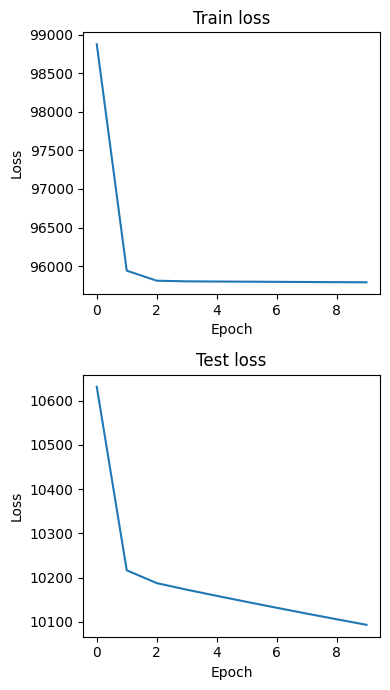

In [19]:
# plot
fig, ax = plt.subplots(2, 1, figsize=(4, 7))

ax[0].plot(list(range(epochs)), loss_bias_train)
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(list(range(epochs)), loss_bias_test)
ax[1].set_title('Test loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.tight_layout();
plt.savefig('loss_train_test_25bias.pdf', format='pdf')

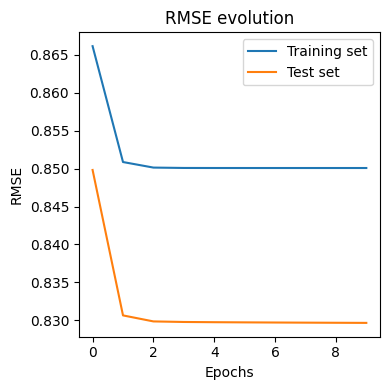

In [18]:
# plot
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(list(range(epochs)), rmse_bias_train, label='Training set')
ax.plot(list(range(epochs)), rmse_bias_test, label='Test set')
ax.set_title('RMSE evolution')
ax.set_xlabel('Epochs')
ax.set_ylabel('RMSE')
ax.legend()

plt.tight_layout();
plt.savefig('rmse_train_test_25bias.pdf', format='pdf')

## With embeddings

In [10]:
def compute_loss_and_rmse_with_embeddings(
    data_by_usr,
    data_by_itm,
    user_biases,
    item_biases,
    lambd=0.1,
    gamma=0.2,
    tau=0.5,
    K=4,
    epoch=20,
):
    # Initialisation
    user_vector = np.random.normal(0, 1/np.sqrt(K), (len(data_by_usr), K))
    item_vector = np.random.normal(0, 1/np.sqrt(K), (len(data_by_itm), K))

    all_loss = np.zeros(epoch)
    all_rmse = np.zeros(epoch)

    for i in range(epoch):
        for m, user_ratings in enumerate(data_by_usr):
            # Update user biases
            bias_sum = np.sum([r - user_vector[m] @ item_vector[n] - item_biases[n] for n, r in user_ratings])
            user_biases[m] = bias_sum / (len(user_ratings) + gamma)

            # Update user vectors
            sum1 = np.zeros((K, K))
            sum2 = np.zeros(K)
            for n, r in user_ratings:
                item_vec = item_vector[n]
                sum1 += np.outer(item_vec, item_vec)
                sum2 += item_vec * (r - user_biases[m] - item_biases[n])

            user_vector[m] = np.linalg.solve(lambd * sum1 + tau * np.identity(K), lambd * sum2)

        
        for n, item_ratings in enumerate(data_by_itm):
            # Update item biases
            bias_sum = np.sum([r - user_vector[m] @ item_vector[n] - user_biases[m] for m, r in item_ratings])
            item_biases[n] = bias_sum / (len(item_ratings) + gamma)

            # Update item vectors
            sum1 = np.zeros((K, K))
            sum2 = np.zeros(K)
            for m, r in item_ratings:
                user_vec = user_vector[m]
                sum1 += np.outer(user_vec, user_vec)
                sum2 += user_vec * (r - user_biases[m] - item_biases[n])

            item_vector[n] = np.linalg.solve(lambd * sum1 + tau * np.identity(K), lambd * sum2)


        # Compute loss and RMSE
        loss_first_term = 0
        rmse_one = 0
        count = 0

        # Error in the loss
        for m, user_ratings in enumerate(data_by_usr):
            for n, r in user_ratings:
                error = r - (user_vector[m] @ item_vector[n] + user_biases[m] + item_biases[n])
                loss_first_term += (error ** 2) 
                rmse_one += error ** 2
                count += 1

        # Regularization terms for users and items
        loss_user_vector = (tau / 2) * np.sum(np.linalg.norm(user_vector, axis=1)**2)
        loss_item_vector = (tau / 2) * np.sum(np.linalg.norm(item_vector, axis=1)**2)

        # Total loss and RMSE calculation
        loss = (lambd/2) * loss_first_term + (gamma/2) * (np.sum(user_biases ** 2) + np.sum(item_biases ** 2)) + loss_user_vector + loss_item_vector
        rmse = np.sqrt(rmse_one / count)

        # Store the results for each epoch
        all_loss[i] = loss
        all_rmse[i] = rmse

        print(f"Epoch {i+1}: loss = {loss:.6f}, rmse = {rmse:.6f}")

    return all_loss, all_rmse


### epochs = 10; lambd = 0.01; gamma = 0.0001; tau = 0.9; K = 50

In [11]:
epochs = 10; lambd = 0.01; gamma = 0.0001; tau = 0.9; K = 50

In [12]:
loss_embed_train1, rmse_embed_train1 = compute_loss_and_rmse_with_embeddings(
                                      data_by_usr = data_by_user_train,
  	                                  data_by_itm = data_by_item_train,
                                      user_biases = np.zeros(len(data_by_user_train)),
  	                                  item_biases = np.zeros(len(data_by_item_train)),
                                      lambd = lambd,
                                      gamma = gamma,
                                      tau = tau,
                                      K = K,
                                      epoch = epochs,
                                      )

Epoch 1: loss = 83978.006391, rmse = 0.853125
Epoch 2: loss = 75326.917329, rmse = 0.782028
Epoch 3: loss = 73335.685654, rmse = 0.751735
Epoch 4: loss = 72896.040160, rmse = 0.741870
Epoch 5: loss = 72741.027912, rmse = 0.737720
Epoch 6: loss = 72667.352651, rmse = 0.735629
Epoch 7: loss = 72625.583774, rmse = 0.734439
Epoch 8: loss = 72599.086742, rmse = 0.733699
Epoch 9: loss = 72580.964719, rmse = 0.733205
Epoch 10: loss = 72567.927652, rmse = 0.732858


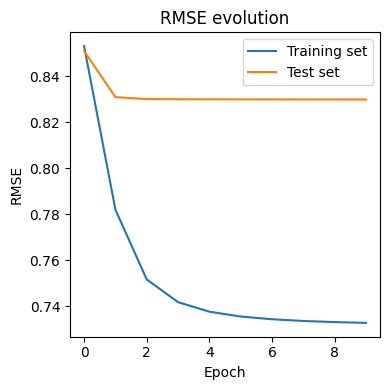

In [7]:
# Rewrite the values to plot
rmse_embed_train1 = np.array([0.853125, 0.782028, 0.751735, 0.741870, 0.737720, 0.735629, 0.734439, 0.733699, 0.733205, 0.732858])
rmse_embed_test1 = np.array([0.850968, 0.830983, 0.830135, 0.830057, 0.830031, 0.830013, 0.829998, 0.829984, 0.829971, 0.829959])

epochs = 10

# plot
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(list(range(epochs)), rmse_embed_train1, label='Training set')
ax.plot(list(range(epochs)), rmse_embed_test1, label='Test set')
ax.set_title('RMSE evolution')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.legend()

plt.tight_layout();
#plt.savefig('rmse_train_test_25.pdf', format='pdf')

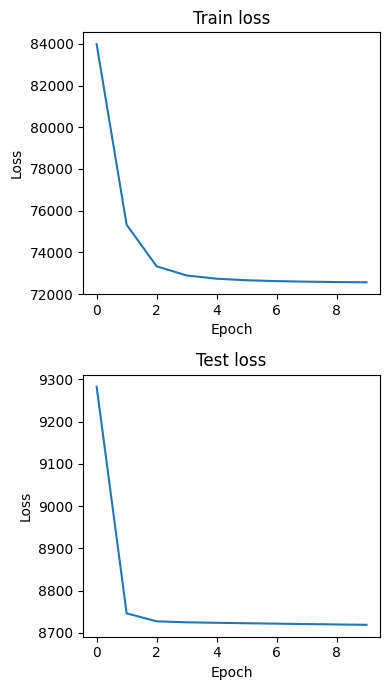

In [10]:
# Rewrite the values to plot
loss_embed_train1 = np.array([83978.006391, 75326.917329, 73335.685654, 72896.040160, 72741.027912, 72667.352651, 72625.583774, 72599.086742, 72580.964719, 72567.927652])
loss_embed_test1 = np.array([9282.735605, 8746.080143, 8727.241659, 8724.917126, 8723.710528, 8722.675006, 8721.698168, 8720.754310, 8719.835193, 8718.937626])

epochs = 10

# plot
fig, ax = plt.subplots(2, 1, figsize=(4, 7))

ax[0].plot(list(range(epochs)), loss_embed_train1)
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(list(range(epochs)), loss_embed_test1)
ax[1].set_title('Test loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.tight_layout();
#plt.savefig('loss_train_test_25.pdf', format='pdf')

### epochs = 10; lambd = 0.01; gamma = 0.0001; tau = 0.9; K = 10

In [47]:
epochs = 10; lambd = 0.01; gamma = 0.0001; tau = 0.9; K = 10

In [48]:
loss_embed_train2, rmse_embed_train2 = compute_loss_and_rmse_with_embeddings(
                                      data_by_usr = data_by_user_train,
  	                                  data_by_itm = data_by_item_train,
                                      user_biases = np.zeros(len(data_by_user_train)),
  	                                  item_biases = np.zeros(len(data_by_item_train)),
                                      lambd = lambd,
                                      gamma = gamma,
                                      tau = tau,
                                      K = K,
                                      epoch = epochs,
                                      )

Epoch 1: loss = 84471.294055, rmse = 0.860392
Epoch 2: loss = 77498.844282, rmse = 0.810134
Epoch 3: loss = 75377.624868, rmse = 0.785781
Epoch 4: loss = 74854.374323, rmse = 0.778206
Epoch 5: loss = 74677.090509, rmse = 0.775254
Epoch 6: loss = 74599.226189, rmse = 0.773867
Epoch 7: loss = 74558.540731, rmse = 0.773126
Epoch 8: loss = 74534.285431, rmse = 0.772689
Epoch 9: loss = 74518.390130, rmse = 0.772411
Epoch 10: loss = 74507.378805, rmse = 0.772223


In [50]:
loss_embed_test2, rmse_embed_test2 = compute_loss_and_rmse_with_embeddings(
                                      data_by_usr = data_by_user_test,
  	                                  data_by_itm = data_by_item_test,
                                      user_biases = np.zeros(len(data_by_user_test)),
  	                                  item_biases = np.zeros(len(data_by_item_test)),
                                      lambd = lambd,
                                      gamma = gamma,
                                      tau = tau,
                                      K = K,
                                      epoch = epochs,
                                      )

Epoch 1: loss = 9312.956728, rmse = 0.853194
Epoch 2: loss = 8723.661829, rmse = 0.830253
Epoch 3: loss = 8705.127554, rmse = 0.829419
Epoch 4: loss = 8702.819631, rmse = 0.829343
Epoch 5: loss = 8701.569016, rmse = 0.829316
Epoch 6: loss = 8700.482223, rmse = 0.829297
Epoch 7: loss = 8699.455375, rmse = 0.829281
Epoch 8: loss = 8698.463455, rmse = 0.829266
Epoch 9: loss = 8697.497889, rmse = 0.829252
Epoch 10: loss = 8696.555194, rmse = 0.829239


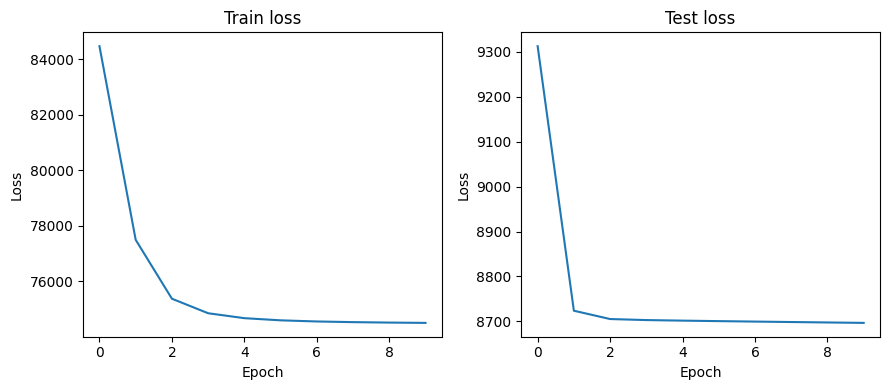

In [52]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

ax[0].plot(list(range(epochs)), loss_embed_train2)
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(list(range(epochs)), loss_embed_test2)
ax[1].set_title('Test loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.tight_layout();
#plt.savefig('loss_train_test_25plot_embed_k10.pdf', format='pdf')
#plt.rc('pgf', texsystem='pdflatex')
#plt.savefig('distr_halo_mass_3box.pgf')
#plt.show()

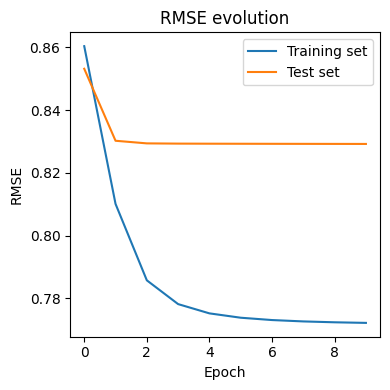

In [55]:
# plot
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(list(range(epochs)), rmse_embed_train2, label='Training set')
ax.plot(list(range(epochs)), rmse_embed_test2, label='Test set')
ax.set_title('RMSE evolution')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.legend()

plt.tight_layout();

### epochs = 10; lambd = 0.01; gamma = 0.0001; tau = 0.9; K = 20

In [40]:
epochs = 10; lambd = 0.01; gamma = 0.0001; tau = 0.9; K = 20

In [41]:
loss_embed_train2, rmse_embed_train2 = compute_loss_and_rmse_with_embeddings(
                                      data_by_usr = data_by_user_train,
  	                                  data_by_itm = data_by_item_train,
                                      user_biases = np.zeros(len(data_by_user_train)),
  	                                  item_biases = np.zeros(len(data_by_item_train)),
                                      lambd = lambd,
                                      gamma = gamma,
                                      tau = tau,
                                      K = K,
                                      epoch = epochs,
                                      )

Epoch 1: loss = 84266.757575, rmse = 0.857300
Epoch 2: loss = 76446.598511, rmse = 0.797489
Epoch 3: loss = 74391.519135, rmse = 0.770640
Epoch 4: loss = 73889.244300, rmse = 0.762011
Epoch 5: loss = 73701.999686, rmse = 0.758402
Epoch 6: loss = 73609.703129, rmse = 0.756562
Epoch 7: loss = 73558.243553, rmse = 0.755521
Epoch 8: loss = 73527.660425, rmse = 0.754897
Epoch 9: loss = 73508.439421, rmse = 0.754503
Epoch 10: loss = 73495.684855, rmse = 0.754242


In [42]:
loss_embed_test, rmse_embed_test = compute_loss_and_rmse_with_embeddings(
                                      data_by_usr = data_by_user_test,
  	                                  data_by_itm = data_by_item_test,
                                      user_biases = np.zeros(len(data_by_user_test)),
  	                                  item_biases = np.zeros(len(data_by_item_test)),
                                      lambd = lambd,
                                      gamma = gamma,
                                      tau = tau,
                                      K = K,
                                      epoch = epochs,
                                      )

Epoch 1: loss = 9280.041064, rmse = 0.851370
Epoch 2: loss = 8723.630607, rmse = 0.830252
Epoch 3: loss = 8705.088366, rmse = 0.829418
Epoch 4: loss = 8702.783082, rmse = 0.829343
Epoch 5: loss = 8701.533662, rmse = 0.829316
Epoch 6: loss = 8700.447590, rmse = 0.829297
Epoch 7: loss = 8699.421367, rmse = 0.829280
Epoch 8: loss = 8698.430068, rmse = 0.829265
Epoch 9: loss = 8697.465133, rmse = 0.829252
Epoch 10: loss = 8696.523077, rmse = 0.829238


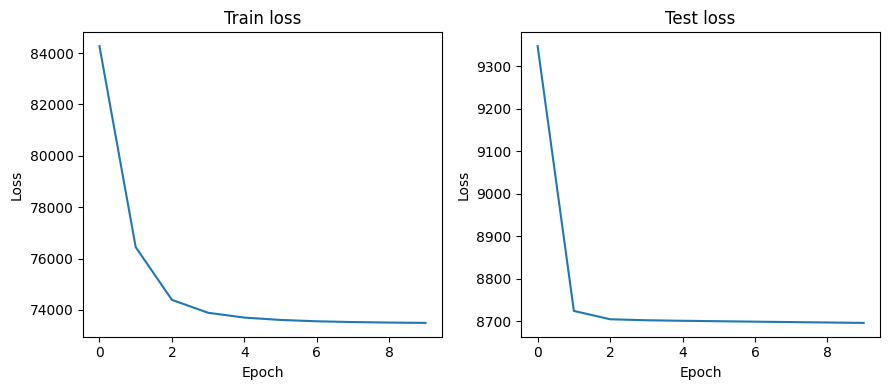

In [45]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

ax[0].plot(list(range(epochs)), loss_embed_train2)
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(list(range(epochs)), loss_embed_test2)
ax[1].set_title('Test loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.tight_layout();

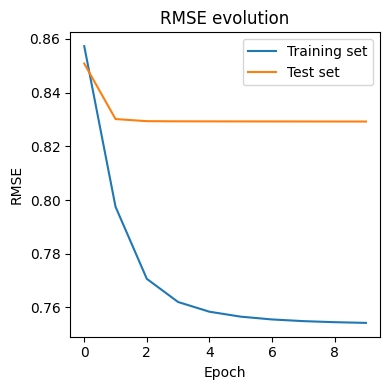

In [46]:
# plot
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(list(range(epochs)), rmse_embed_train2, label='Training set')
ax.plot(list(range(epochs)), rmse_embed_test2, label='Test set')
ax.set_title('RMSE evolution')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.legend()

plt.tight_layout();

# All data epochs 30

In [ ]:
# load trained user and item biases and vectors
user_vec = np.load('usr_vect50.npy')
user_bi = np.load('usr_bias50.npy')
item_vec = np.load('itm_vect50.npy')
item_bi = np.load('itm_bias50.npy')

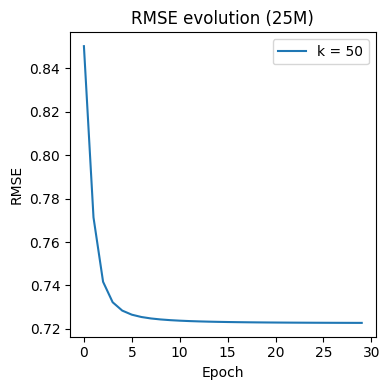

In [5]:
import matplotlib.pyplot as plt

epochs = 30

# plot
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(list(range(epochs)), rmse_k50, label='k = 50')
ax.set_title('RMSE evolution (25M)')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.legend()

plt.tight_layout();
plt.savefig('rmse_allk50.pdf', format='pdf')

# Predictions

In [75]:
import numpy as np
epochs = 30; lambd = 0.01; gamma = 0.0001; tau = 0.9; K = 50

item_vector = item_vec
user_biases = user_bi
item_biases = item_bi

new_user = [[(0, 5)]]
user_vector = np.random.normal(0, 1/np.sqrt(K), (len(new_user), K))


for i in range(3):
    for m in range(len(new_user)):
        # update user vectors
        sum1 = np.zeros((K, K))
        sum2 = np.zeros(K)
        for (n, r) in new_user[m]:
            sum1 += np.outer(item_vector[n,:], item_vector[n,:])
            sum2 += item_vector[n,:] * (r - user_biases[m] - item_biases[n])
        u_first_term = lambd * sum1 + tau * np.identity(K)
        user_vector[m,:] = np.dot(np.linalg.inv(u_first_term), lambd * sum2)


In [91]:
score_item = np.zeros(len(data_by_movie_index))

for n in range(len(data_by_movie_index)):
    score_item[n] = np.abs(np.inner(user_vector, item_vec[n]) + item_bi[n])

score_item

/tmp/ipykernel_14755/3364463409.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score_item[n] = np.abs(np.inner(user_vector, item_vec[n]) + item_bi[n])


array([1.15845623, 0.49587583, 0.40776169, ..., 0.479823  , 0.02012689,
       0.02012689])

In [12]:
ratings = "ratings25m.csv"
movies = "movies25m.csv"
tags = "tags25m.csv"

In [19]:
import pandas as pd

ratings_df = pd.read_csv(ratings)
movies_df = pd.read_csv(movies)
tags_df = pd.read_csv(tags)

In [33]:
movies_df[movies_df['title'].str.contains("Lord of the Rings")]

,movieId,title,genres
2026,2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy
4887,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
5840,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
7028,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy


In [37]:
movies_df.loc[movies_df['movieId'].isin(top5)]

,movieId,title,genres
28,29,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
40,41,Richard III (1995),Drama|War
47,48,Pocahontas (1995),Animation|Children|Drama|Musical|Romance
842,860,"Maybe, Maybe Not (Bewegte Mann, Der) (1994)",Comedy
